In [90]:
import pandas as pd
import codecs
import matplotlib.pyplot as plt
import numpy as np
import odf
import math
import pdfkit
from itertools import chain
from statistics import mean
from uncertainties import ufloat, ufloat_fromstr
from uncertainties.umath import *
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit, minimize_scalar
from lmfit.models import LorentzianModel
from IPython.display import display, Latex
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

X = "Time [$s$]"
Y = "Voltage [$V$]"
ref = 1.63

### Monitoring of Laser Stability

In [2]:
f = codecs.open('1_HeNe.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
HeNe = pd.read_csv('new.txt', skiprows=5, usecols=[0, 1], names=[X, Y])
HeNe.style.set_caption("For HeNe Laser")

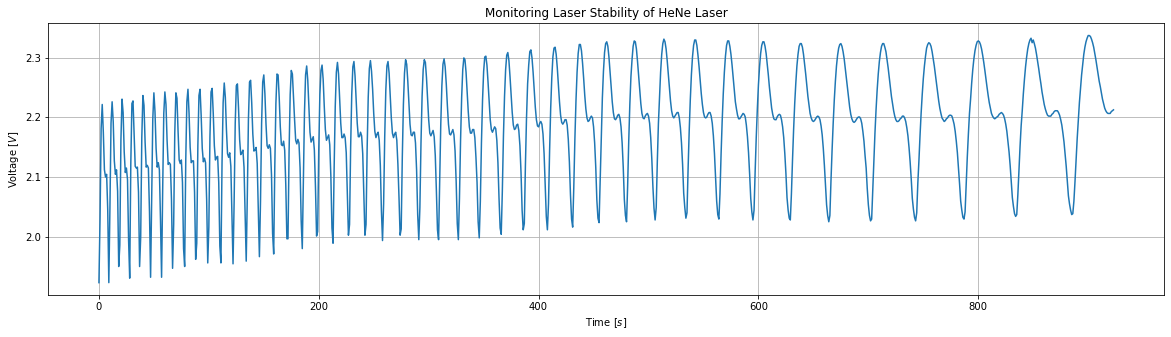

In [3]:
plt.figure(figsize=(20,5))
plt.plot(np.array(HeNe[X]), np.array(HeNe[Y]))
plt.xlabel(X)
plt.ylabel(Y)
plt.title("Monitoring Laser Stability of HeNe Laser")
plt.grid()
plt.show()

In [4]:
f = codecs.open('1_green.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p1green = pd.read_csv('new.txt', skiprows=5, usecols=[0, 1], names=[X, Y])
p1green.style.set_caption("For Green Laser")

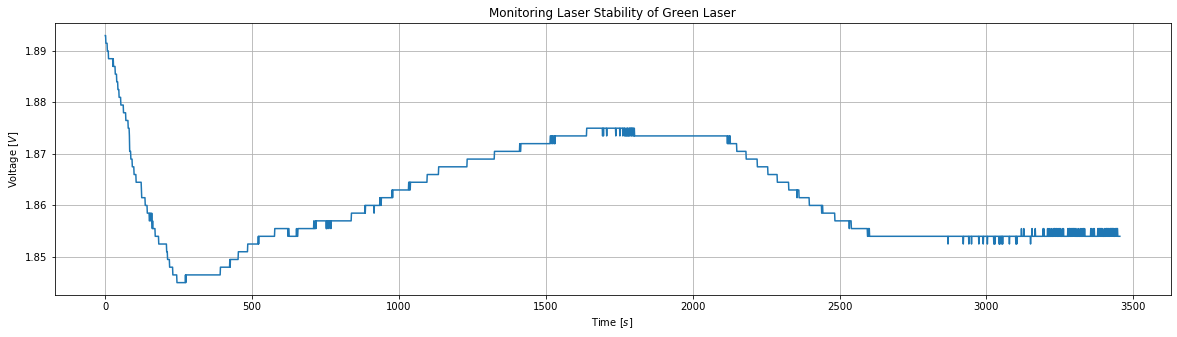

In [5]:
plt.figure(figsize=(20,5))
plt.plot(np.array(p1green[X]), np.array(p1green[Y]))
plt.xlabel(X)
plt.ylabel(Y)
plt.title('Monitoring Laser Stability of Green Laser')
plt.grid()
plt.show()

In [6]:
f = codecs.open('1_background.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
background = pd.read_csv('new.txt', skiprows=5, usecols=[0, 1], names=[X, Y])
display(Latex('Background Signal measured ${:10.4f} \ V$'.format(background[Y].mean())))

<IPython.core.display.Latex object>

### Polarization direction of green laser and Malus Law

In [91]:
X = "$𝜃$"
Y = "Voltage [$V$]"
Z = "Normalized Voltage [$V$]"
BackOff = background[Y].mean()
angles = np.array([i for i in range(-90, 91, 10)])
df = pd.DataFrame(data=angles, columns=[X])

In [36]:
f = codecs.open('2_-90to90.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p2a = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=[Y])
p2a = pd.concat([df, p2a], axis=1)

In [37]:
p2a[Z] = p2a[Y] - np.min(p2a[Y])
A = np.array(p2a[X]).reshape(-1, 1)
B = np.array(p2a[Z]).reshape(-1, 1)
p2a.style.set_caption("Photodiode Signal when illuminated by green laser")

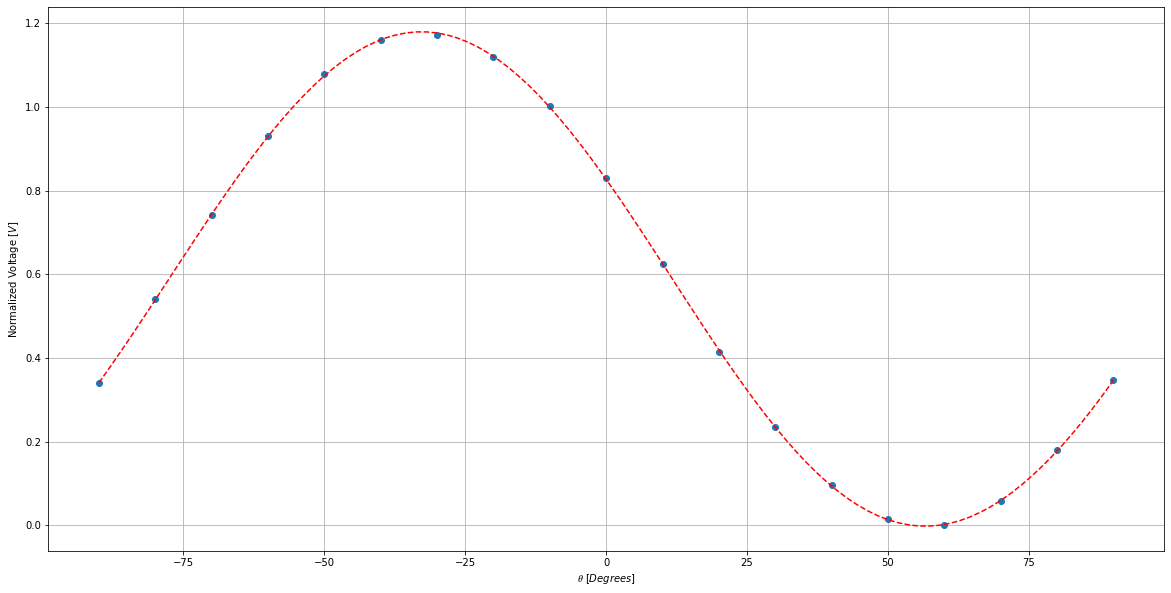

In [38]:
def linelikeexcel(x,y):
    coefs = np.polyfit(x,y,deg=8)
    p_obj = np.poly1d(coefs)
    return p_obj

p_objt = linelikeexcel(np.array(df[X]), np.array(p2a[Z]))

x_line = np.linspace(min(np.array(df[X])), max(np.array(df[X])), 100)
y_linet = p_objt(x_line)

plt.figure(figsize=(20,10))
plt.plot(np.array(df[X]), np.array(p2a[Z]), 'o')
plt.plot(x_line,y_linet, 'r--')

plt.xlabel(X + ' $[Degrees]$')
plt.ylabel(Z)

plt.grid()
plt.show()

maximum: -32.94559113452717 1.1747829861460939
[  1.17478299 -32.94559065]
[0.00214748 0.08733663]


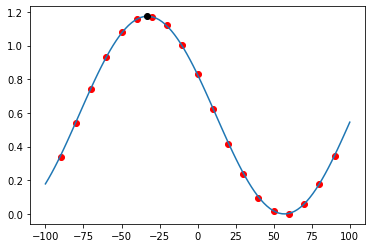

In [103]:
x = np.array(df[X])
y = np.array(p2a[Z])

def f(x, p1, p2):
    return p1 * (np.cos(np.deg2rad(x-p2)))**2

p0 = (5, 45)
plt.plot(x,y,"ro")
popt, pcov = curve_fit(f, x, y, p0)

# find the peak
fm = lambda x: -f(x, *popt)
r = minimize_scalar(fm, bounds=(-75, -1))
print("maximum:", r["x"], f(r["x"], *popt))
print(popt)
print(np.sqrt(np.diag(pcov)))

x_curve = np.linspace(-100, 100, 100)
plt.plot(x_curve, f(x_curve, *popt))
plt.plot(r['x'], f(r['x'], *popt), 'ko')
plt.show()

In [102]:
x = ufloat(np.deg2rad(-32.94559062), np.deg2rad(0.01))
e = 1.17478299/((cos((x)))**2)
print(e)

1.6682+/-0.0004


#### From graph, maximum angle was measured to be, $\alpha = -32.8^{\circ}$.

In [111]:
max_angle = -33.64
p2a['$φ$'] = max_angle - p2a[X]
p2a['$cos^2φ$'] = (np.cos(np.deg2rad(p2a['$φ$'])))**2
p2a

$𝜃$  Voltage [$V$]  Normalized Voltage [$V$]     $φ$  $cos^2φ$
0   -90         0.4245                    0.3405   56.36  0.306886
1   -80         0.6240                    0.5400   46.36  0.476272
2   -70         0.8250                    0.7410   36.36  0.648521
3   -60         1.0140                    0.9300   26.36  0.802855
4   -50         1.1625                    1.0785   16.36  0.920661
5   -40         1.2435                    1.1595    6.36  0.987729
6   -30         1.2570                    1.1730   -3.64  0.995969
7   -20         1.2045                    1.1205  -13.64  0.944389
8   -10         1.0875                    1.0035  -23.64  0.839208
9     0         0.9135                    0.8295  -33.64  0.693114
10   10         0.7080                    0.6240  -43.64  0.523728
11   20         0.4980                    0.4140  -53.64  0.351479
12   30         0.3195                    0.2355  -63.64  0.197145
13   40         0.1800                    0.0960  -73.64  0.079339
14   50         0.0990                    0.0150  -83.64  0.012271
15   60         0.0840                    0.0000  -93.64  0.004031
16   70         0.1410                    0.0570 -103.64  0.055611
17   80         0.2640                    0.1800 -113.64  0.160792
18   90         0.4305                    0.3465 -123.64  0.306886

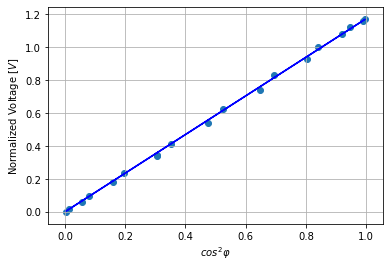

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [112]:
B = np.array(p2a[Z]).reshape(-1, 1)
A = np.array(p2a['$cos^2φ$']).reshape(-1, 1)
reg = LinearRegression(fit_intercept=False).fit(A, B)
Y_pred = reg.predict(A)
reg_value = reg.score(A, B)
intercept = reg.intercept_
coef = reg.coef_
error = np.sqrt((1/(p2a[X].describe().loc['count'] - 2)) * (1 - ((reg_value) ** 2))/((reg_value) ** 2)) * coef
slope = np.sum(np.array(p2a['$cos^2φ$']) * np.array(p2a[Z])) / np.sum(np.array(p2a['$cos^2φ$'])**2)
merr = (1/(p2a[X].describe().loc['count'] - 1)) * (np.sum((np.array(p2a[Z]) - (slope * np.array(p2a['$cos^2φ$'])))**2))/ (np.sum(np.array(p2a['$cos^2φ$'])**2))
# print(np.sqrt(merr))


# plt.figure(figsize=(5,5))
plt.scatter(A, B)
plt.plot(A, Y_pred, color='blue')
plt.xlabel('$cos^2φ$')
plt.ylabel('Normalized Voltage $[V]$')
plt.grid()
plt.show()
display(Latex("$R^2$ = {:10.8f}".format(reg_value)))
display(Latex("$f(x) = {:10.8f}x  + {:10.2f}$".format(coef[0, 0], intercept)))
display(Latex("$\Delta m = {:10.7f}$".format(error[0][0])))

### Fresnel's reflection coefficients and Brewester angle

In [13]:
Brewster_angle = np.rad2deg(np.arctan(ref))
np.format_float_positional(Brewster_angle, precision=4, unique=False, fractional=False, trim='k')
display(Latex('Calculated value of Brewster angle for refractive index $n = 1.63 \ is \ {:10.2f}^\circ$'.format(Brewster_angle)))

<IPython.core.display.Latex object>

In [115]:
angles = np.array([i for i in range(15, 52, 5)] + [i for i in range(53, 64)] + [i for i in range(65, 90, 5)])
df = pd.DataFrame(data=angles, columns=[X])

#### For s-polarization

In [15]:
f = codecs.open('3d_s_primary.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
sprimarypd = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=[Y])
sprimary = sprimarypd[Y].mean()
def calc_rsp(inci):
    r_sp =  ((np.sqrt(ref**2 - (np.sin(np.deg2rad(inci)))**2) - np.sqrt(1 - (np.sin(np.deg2rad(inci)))**2))**2)/(ref**2 - 1)
    return r_sp

theoreticalr = np.array([calc_rsp(i) for i in angles])
st = pd.DataFrame(data=theoreticalr, columns=['rt'])
print(sprimary)

1.0545


In [16]:
f = codecs.open('3d_s.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p3s1 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['$I_r [V]$'])

In [17]:
p3s = pd.concat([df, p3s1], axis=1)
p3s['$r^\perp$'] = np.sqrt(p3s['$I_r [V]$']/sprimary)
p3s

$𝜃$  $I_r [V]$  $r^\perp$
0    15     0.0510   0.219919
1    20     0.0645   0.247318
2    25     0.0705   0.258566
3    30     0.0765   0.269344
4    35     0.0900   0.292145
5    40     0.0930   0.296974
6    45     0.1050   0.315552
7    50     0.1215   0.339441
8    53     0.1335   0.355809
9    54     0.1380   0.361756
10   55     0.1425   0.367607
11   56     0.1500   0.377157
12   57     0.1515   0.379038
13   58     0.1530   0.380910
14   59     0.1560   0.384626
15   60     0.1620   0.391953
16   61     0.1665   0.397360
17   62     0.1695   0.400924
18   63     0.1800   0.413155
19   65     0.2055   0.441451
20   70     0.2580   0.494637
21   75     0.3210   0.551733
22   80     0.4035   0.618584
23   85     0.5745   0.738111

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
<ipython-input-18-7f5c5e0f029e>:28: RuntimeWarning: invalid value encountered in true_divide
  return ((np.sqrt(a**2 - (np.sin(np.deg2rad(x)))**2) - np.sqrt(1 - (np.sin(np.deg2rad(x)))**2))**2)/(

[ 2.36052003e-06 -2.42816620e-04  1.09514261e-02  1.02006688e-01]
[1.]
[1.58]


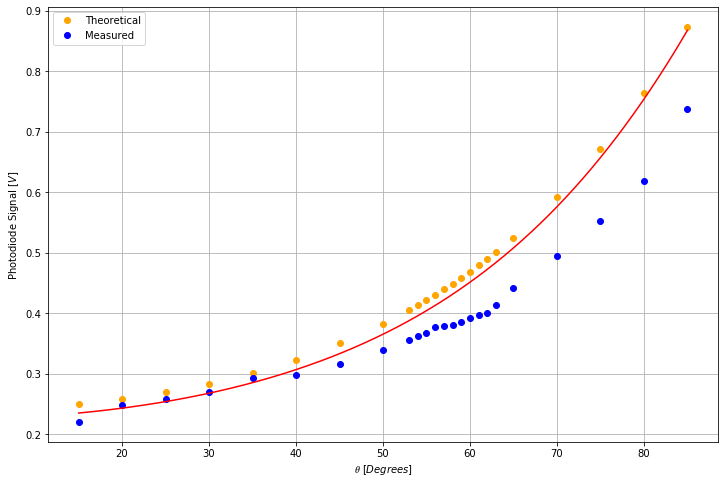

In [18]:
def linelikeexcel(x,y):
    coefs = np.polyfit(x,y,deg=8)
    p_obj = np.poly1d(coefs)
    return p_obj

# p_objs = linelikeexcel(np.array(df[X]), np.array(p3s['$r^\perp$']))
p_objst = linelikeexcel(np.array(df[X]), np.array(st['rt']))

x_line = np.linspace(min(df[X]), max(df[X]), 100)
# y_lines = p_objs(x_line)
y_linest = p_objst(x_line)


plt.figure(figsize=(12,8))
# plt.plot(df[X], p3s['$r^\perp$'], 'o', color='blue', label='Measured')
plt.plot(df[X], st['rt'], 'o', color='orange', label='Theoretical')
# plt.plot(x_line,y_lines, 'r--', color='green') 
# plt.plot(x_line, y_linest, 'g--')
plt.xlabel('$𝜃 \ [Degrees]$')
plt.ylabel('Photodiode Signal $[V]$')


plt.grid()
# plt.show()


def func(x, a):
  return ((np.sqrt(a**2 - (np.sin(np.deg2rad(x)))**2) - np.sqrt(1 - (np.sin(np.deg2rad(x)))**2))**2)/(a**2 - 1)

x = angles
y = np.array(p3s['$r^\perp$'])

print(np.polyfit(x, y, 3))

popt, _ = curve_fit(func, x, y)
print(popt)

popt_cons, _ = curve_fit(func, x, y, bounds=([1.58], [1.64]))
print(popt_cons)

xnew = np.linspace(x[0], x[-1], 1000)

plt.plot(x, y, 'bo', label='Measured')
plt.plot(xnew, func(xnew, *popt), 'k-')
plt.legend()
plt.plot(xnew, func(xnew, *popt_cons), 'r-')
plt.show()

#### For p-polarization

In [19]:
f = codecs.open('3_p_primary.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
pprimarypd = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=[Y])
pprimary = pprimarypd[Y].mean()
def calc_rpp(inci):
    r_pp = (((ref**2)*(np.sqrt(1 - (np.sin(np.deg2rad(inci)))**2))) - (np.sqrt(ref**2 - (np.sin(np.deg2rad(inci)))**2)))/((ref**2)*(np.sqrt(1 - (np.sin(np.deg2rad(inci)))**2)) + (np.sqrt(ref**2 - (np.sin(np.deg2rad(inci)))**2)))
    return r_pp

theoreticalr = np.array([calc_rpp(i) for i in angles])
pt = pd.DataFrame(data=np.abs(theoreticalr), columns=['rt'])
print(pprimary)

0.3885


In [20]:
f = codecs.open('3_p.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p3p1 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['$I_r [V]$'])
p3p1['$I_r [V]$'] = p3p1['$I_r [V]$'] - background[Y].mean()

In [21]:
p3p = pd.concat([df, p3p1], axis=1)
p3p['$r^\parallel$'] = np.sqrt(p3p['$I_r [V]$']/pprimary)
p3p.style.set_caption("Background offset has been substracted")

[ 1.13753239e-05 -1.38757890e-03  4.64940118e-02 -1.99592552e-01]
[0.99632353] [[2.95776777e-08]]
[1.68] [0.3821456]


<ipython-input-30-13eaf15728b7>:27: RuntimeWarning: invalid value encountered in sqrt
  return (((a**2)*(np.sqrt(1 - (np.sin(np.deg2rad(x)))**2))) - (np.sqrt(a**2 - (np.sin(np.deg2rad(x)))**2)))/((a**2)*(np.sqrt(1 - (np.sin(np.deg2rad(x)))**2)) + (np.sqrt(a**2 - (np.sin(np.deg2rad(x)))**2)))


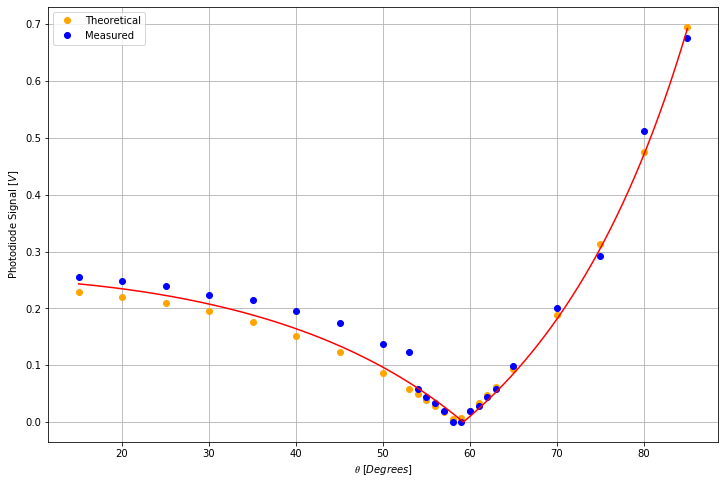

[0.99632353] [[0.14603526]] [1.68]


In [30]:
def linelikeexcel(x,y):
    coefs = np.polyfit(x,y,deg=8)
    p_obj = np.poly1d(coefs)
    return p_obj

# p_objp = linelikeexcel(df[X], np.array(p3p['$r^\parallel$']))
p_objpt = linelikeexcel(df[X], pt['rt'])

x_line = np.linspace(min(df[X]), max(df[X]), 100)
# y_linep = p_objp(x_line)
y_linept = p_objpt(x_line)

plt.figure(figsize=(12,8))


# plt.plot(df[X], p3p['$r^\parallel$'], 'o', color='blue', label='Measured')
plt.plot(df[X], pt['rt'], 'o', color='orange', label='Theoretical')
# plt.plot(x_line,y_linep, 'r--', color='green') 
# plt.plot(x_line, y_linept, 'r--')
# plt.legend()
plt.xlabel('$𝜃 \ [Degrees]$')
plt.ylabel('Photodiode Signal $[V]$')

plt.grid()

def func(x, a):
  return (((a**2)*(np.sqrt(1 - (np.sin(np.deg2rad(x)))**2))) - (np.sqrt(a**2 - (np.sin(np.deg2rad(x)))**2)))/((a**2)*(np.sqrt(1 - (np.sin(np.deg2rad(x)))**2)) + (np.sqrt(a**2 - (np.sin(np.deg2rad(x)))**2)))
x = angles
y = np.array(p3p['$r^\parallel$'])

print(np.polyfit(x, y, 3))

popt, _ = curve_fit(func, x, y)
print(popt, _)

popt_cons, _ = curve_fit(func, x, y, bounds=([1.1], [1.68]))
print(popt_cons, np.sqrt(np.diag(_)))

xnew = np.linspace(x[0], x[-1], 1000)

plt.plot(x, y, 'bo', label='Measured')
plt.legend()
plt.plot(xnew, np.abs(func(xnew, *popt_cons)), 'r-')
plt.show()
print(popt, _, popt_cons)

[[0.15530371]]


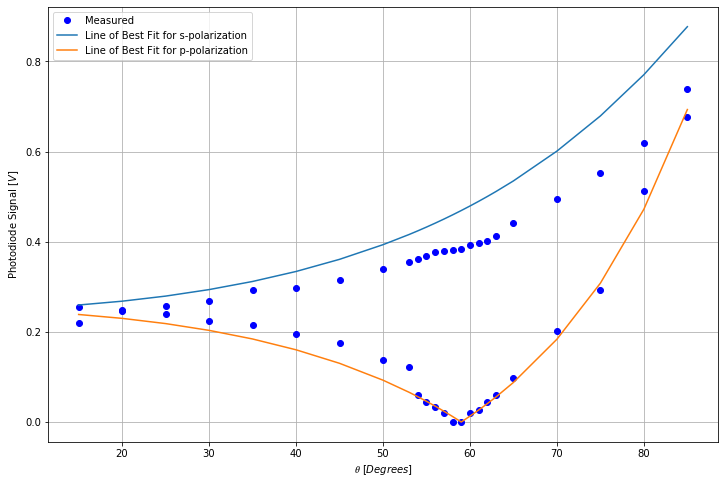

[1.66375719]


In [124]:
y1 = np.array(p3s['$r^\perp$'])
y2 = np.array(p3p['$r^\parallel$'])
comboY = np.append(y1, y2)

h = angles
comboX = np.append(h, h)


def mod1(x, a):
        return ((np.sqrt(a**2 - (np.sin(np.deg2rad(x)))**2) - np.sqrt(1 - (np.sin(np.deg2rad(x)))**2))**2)/(a**2 - 1)


def mod2(x, a):
        return (((a**2)*(np.sqrt(1 - (np.sin(np.deg2rad(x)))**2))) - (np.sqrt(a**2 - (np.sin(np.deg2rad(x)))**2)))/((a**2)*(np.sqrt(1 - (np.sin(np.deg2rad(x)))**2)) + (np.sqrt(a**2 - (np.sin(np.deg2rad(x)))**2)))


def comboFunc(comboData, a):
    extract1 = comboData[:len(y1)]
    extract2 = comboData[len(y2):]

    result1 = mod1(extract1, a)
    result2 = mod2(extract2, a)

    return np.append(result1, result2)


initialParameters = np.array([1.63])

fittedParameters, pcov = curve_fit(comboFunc, comboX, comboY, initialParameters)
print(np.sqrt(pcov))

a = fittedParameters

y_fit_1 = mod1(h, a)
y_fit_2 = mod2(h, a)
# print([x for x in h if h[int(x)] == min(np.abs(y_fit_2))])


plt.figure(figsize=(12,8))
plt.plot(comboX, comboY, 'bo', label='Measured')
plt.plot(h, y_fit_1, label='Line of Best Fit for s-polarization')
plt.plot(h, np.abs(y_fit_2), label='Line of Best Fit for p-polarization')
plt.xlabel('$𝜃 \ [Degrees]$')
plt.ylabel('Photodiode Signal $[V]$')
plt.legend()
plt.grid()
plt.show()

print(fittedParameters)

In [ ]:
>>> import numpy as np
>>> import statsmodels.api as sm
>>> lowess = sm.nonparametric.lowess
>>> x = df[X]
y1 = p3p['$r^\parallel$']

filtered = lowess(y1, x)

plt.plot(x, y1, 'r')
plt.plot(filtered[:,0], filtered[:,1], 'b')

### Brewster angle and rotation of polarization vector

In [ ]:
def brewster(inci):
    ang = np.rad2deg(np.arctan(-(np.sqrt((1-(np.sin(np.deg2rad(inci)))**2) * (ref**2 - (np.sin(np.deg2rad(inci)))**2)))/(np.sin(np.deg2rad(inci)))**2))
    return ang
theoreticalang = np.array(brewster(df[X]))

In [ ]:
def linelikeexcel(x,y):
    coefs = np.polyfit(x,y,deg=8)
    p_obj = np.poly1d(coefs)
    return p_obj

p_objt = linelikeexcel(df[X], theoreticalang)

x_line = np.linspace(min(df[X]), max(df[X]), 100)
y_linet = p_objt(x_line)

plt.plot(df[X], theoreticalang, 'o')
plt.plot(x_line,y_linet, 'r--')
plt.xlabel('Angle of incidence')
plt.ylabel('Rotation of polarization vector')

plt.grid()
plt.show()

### Polarization by quarterwave and halfwave plates

##### Quarterwave Plate

In [ ]:
display(Latex('Minimum signal was observed to be $0.013 \ V$ at $66^{\circ}$.'))

f = codecs.open('4_pol_0.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p0 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['0'])


f = codecs.open('4_pol_30.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p30 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['30'])

f = codecs.open('4_pol_45.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p45 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['45'])

f = codecs.open('4_pol_60.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p60 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['60'])

f = codecs.open('4_pol_90.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p90 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['90'])


angles = np.array([i for i in range(-90, 91, 10)])
df = pd.DataFrame(data=angles, columns=['𝜃'])
p4c = pd.concat([df, p0, p30, p45, p60, p90], axis=1)
p4c.style.set_caption("Polarizer set to different angles")

In [ ]:
def linelikeexcel(x,y):
    coefs = np.polyfit(x,y,deg=8)
    p_obj = np.poly1d(coefs)
    return p_obj

plt.figure(figsize=(12,8))
x_line = np.linspace(min(angles), max(angles), 100)
y = [p0['0'], p30['30'], p45['45'], p60['60'], p90['90']]
labels = ['$0^{\circ}$', '$30^{\circ}$', '$45^{\circ}$', '$60^{\circ}$', '$90^{\circ}$']
for i in range(5):
    p_objt = linelikeexcel(angles, y[i])
    y_linet = p_objt(x_line)
    plt.plot(x_line,y_linet, label=labels[i])


plt.xlabel('Orientation angle of the Analyzer,$𝜃  \ [Degrees]$')
plt.ylabel('Photodiode Signal $[V]$')
plt.grid()
plt.legend(title= 'Angle of the Polarizer',bbox_to_anchor=(1.02, 1.02))
plt.show()


In [ ]:
# f = codecs.open('4c_0.txt').read().replace('\t', ',')
# i = open('new.txt', "w")
# i.write(f)
# i.close()
# p0 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['0'])


f = codecs.open('4c_30.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p30 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['30'])

f = codecs.open('4c_45.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p45 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['45'])

f = codecs.open('4c_60.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p60 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['60'])

f = codecs.open('4c_90.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p90 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['90'])


angles = np.array([i for i in range(-90, 91, 10)])
df = pd.DataFrame(data=angles, columns=['𝜃'])
p4cd = pd.concat([df, p30, p45, p60, p90], axis=1)
p4cd.style.set_caption("Quarterwave set to different angles")

In [ ]:
def linelikeexcel(x,y):
    coefs = np.polyfit(x,y,deg=8)
    p_obj = np.poly1d(coefs)
    return p_obj

plt.figure(figsize=(12,8))
x_line = np.linspace(min(angles), max(angles), 100)
y = [p30['30'], p45['45'], p60['60'], p90['90']]
labels = ['$30^{\circ}$', '$45^{\circ}$', '$60^{\circ}$', '$90^{\circ}$']
for i in range(4):
    p_objt = linelikeexcel(angles, y[i])
    y_linet = p_objt(x_line)
    plt.plot(x_line,y_linet, label=labels[i])

plt.grid()
plt.xlabel('Orientation angle of the Quarterwave plate,$𝜃  \ [Degrees]$')
plt.ylabel('Photodiode Signal $[V]$')
plt.legend(title= 'Angle of the Quarterwave plate',bbox_to_anchor=(1.02, 1.02))
plt.show()

#### Halfwave plate

In [ ]:
display(Latex('Minimum signal of the second waveplate added was observed at $33^{\circ}$.'))


f = codecs.open('4d_0.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p0 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['0'])


f = codecs.open('4d_15.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p30 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['15'])

f = codecs.open('4d_30.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p45 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['30'])

f = codecs.open('4d_45.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p60 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=['45'])

f = codecs.open('4d_30change.txt').read().replace('\t', ',')
i = open('new.txt', "w")
i.write(f)
i.close()
p90 = pd.read_csv('new.txt', skiprows=5, usecols=[1], names=["30'"])


angles = np.array([i for i in range(-90, 91, 10)])
df = pd.DataFrame(data=angles, columns=['𝜃'])
p4cd = pd.concat([df, p0, p30, p45, p60, p90], axis=1)
p4cd.style.set_caption("Alignment of two quarterwave plates")

In [ ]:
def linelikeexcel(x,y):
    coefs = np.polyfit(x,y,deg=8)
    p_obj = np.poly1d(coefs)
    return p_obj

plt.figure(figsize=(12,8))
x_line = np.linspace(min(angles), max(angles), 100)
y = [p0['0'], p30['15'], p45['30'], p60['45'], p90["30'"]]
labels = ['$0^{\circ}$', '$15^{\circ}$', '$30^{\circ}$', '$45^{\circ}$', "$\lambda/4$ for second quarterwave plate sideways"]
for i in range(5):
    p_objt = linelikeexcel(angles, y[i])
    y_linet = p_objt(x_line)
    plt.plot(x_line,y_linet, label=labels[i])


plt.grid()
plt.xlabel('Orientation angle of the Quarterwave plate, $𝜃  \ [Degrees]$')
plt.ylabel('Photodiode Signal $[V]$')
plt.legend(title= 'Angle of the Quarterwave plate',bbox_to_anchor=(1.02, 1.02))
plt.show()